In [1]:
import pandas as pd
import numpy as np
import scipy.stats

trialOrders = {}

import os

path = './events'


def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]


def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))

outputdict = {'ID':[], 'skourascore_down': [], 'skourascore_down_90': [], 'skourascore_up': [], 'skourascore_up_90': [], 'skourascore_both': [], 'skourascore_both_90': []}

scoreseries = {'ID':[]}
for i in range(1, 13):
    scoreseries[str(i)] = []
    
downseries = {'ID':[]}
for i in range(1, 7):
    downseries[str(i)] = []
    
upseries = {'ID':[]}
for i in range(1, 7):
    upseries[str(i)] = []

In [2]:
for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #print(subjID)
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    down_skourascores = []
    down_skourascores_90 = []
    up_skourascores = []
    up_skourascores_90 = []
    both_skourascores = []
    both_skourascores_90 = []
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]
        length = len(this_trial.needle_position.values)
        #print("Trial", trialnum + 1, "was", (length-1)*2, "seconds long and contained", length, "needle_position values.")
        #print("needle_position values")
        #print(this_trial.needle_position.values)
        #print(trialOrder[(trialnum * 2)])
        if trialOrder[(trialnum * 2) + 1] == "Focus":
            if trialOrder[(trialnum * 2)] == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
            elif trialOrder[(trialnum * 2)] == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            down_skourascores += [skourascore]
            if length == 46:
                down_skourascores_90 += [skourascore]
        elif trialOrder[(trialnum * 2) + 1] == "Wander":
            if trialOrder[(trialnum * 2)] == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
            elif trialOrder[(trialnum * 2)] == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            up_skourascores += [skourascore]
            if length == 46:
                up_skourascores_90 += [skourascore]
        else:
            print("something is horribly wrong")
        both_skourascores += [skourascore]
        if length == 46:
            both_skourascores_90 += [skourascore]
    #print(down_skourascores)
    outputdict['ID'] += [subjID]
    outputdict['skourascore_down'] += [np.mean(down_skourascores)]
    outputdict['skourascore_down_90'] += [np.mean(down_skourascores_90)]
    outputdict['skourascore_up'] += [np.mean(up_skourascores)]
    outputdict['skourascore_up_90'] += [np.mean(up_skourascores_90)]
    outputdict['skourascore_both'] += [np.mean(both_skourascores)]
    outputdict['skourascore_both_90'] += [np.mean(both_skourascores_90)]
    #print(subjID, np.mean(down_skourascores))
    
    scoreseries['ID'] += [subjID]
    for i in range(1, 13):
        scoreseries[str(i)] += [both_skourascores[i - 1]]
    downseries['ID'] += [subjID]
    for i in range(1, 7):
        downseries[str(i)] += [down_skourascores[i - 1]]
    upseries['ID'] += [subjID]
    for i in range(1, 7):
        upseries[str(i)] += [up_skourascores[i - 1]]
#print(scoreseries)

/home/rouse/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
df = pd.DataFrame(outputdict)
df = df.sort_values(by=['ID'])
print(df)
df.to_csv("./newout.tsv", sep="\t", index=False)

            ID  skourascore_down  skourascore_down_90  skourascore_up  \
55   A00028185          0.016352            -0.053907       -0.298887   
74   A00032875         -0.528836             0.093946        0.349334   
109  A00033747          0.444372             0.911257        0.047072   
37   A00034854          0.395348             0.681288       -0.148989   
7    A00035072          0.624165             0.615793        0.703747   
..         ...               ...                  ...             ...   
42   A00066827         -0.098758            -0.310026        0.233062   
28   A00066926          0.406654             0.025461        0.049357   
34   A00072203          0.005606            -0.104370        0.158520   
2    A00073600          0.087554             0.018960        0.593002   
72   A00073677         -0.141997            -0.649310       -0.252080   

     skourascore_up_90  skourascore_both  skourascore_both_90  
55           -0.327317         -0.141267            -0.1906

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


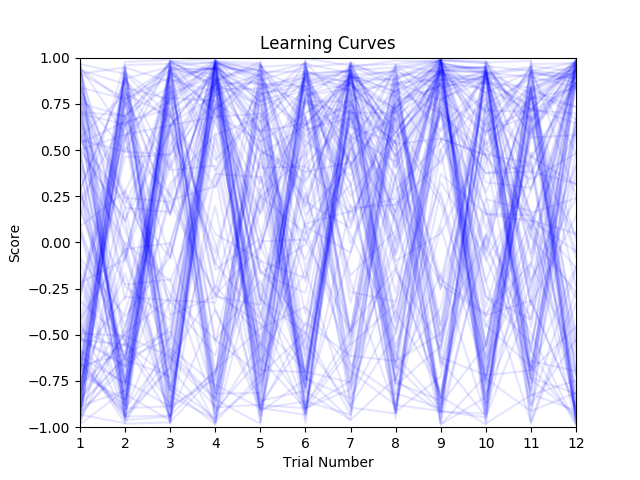

In [5]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(12):
    x += [i + 1]
series = pd.DataFrame(scoreseries)
series = series.sort_values(by=['ID'])
series = series.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(series)):
    ax.plot(x, series[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 12))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('Learning Curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

<IPython.core.display.Javascript object>


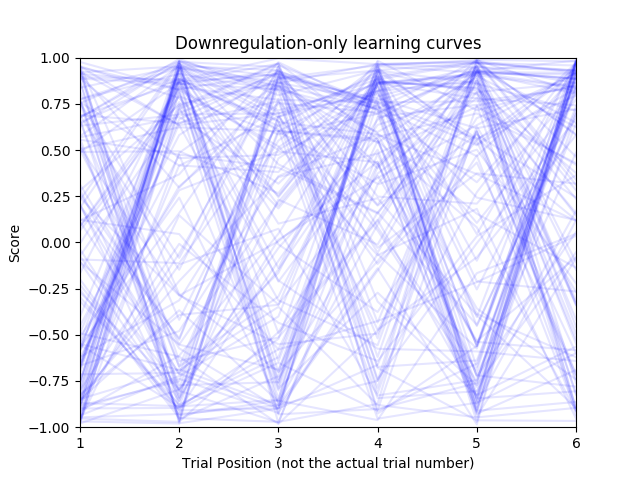

In [6]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
dseries = pd.DataFrame(downseries)
dseries = dseries.sort_values(by=['ID'])
dseries = dseries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(dseries)):
    ax.plot(x, dseries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('Downregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

<IPython.core.display.Javascript object>


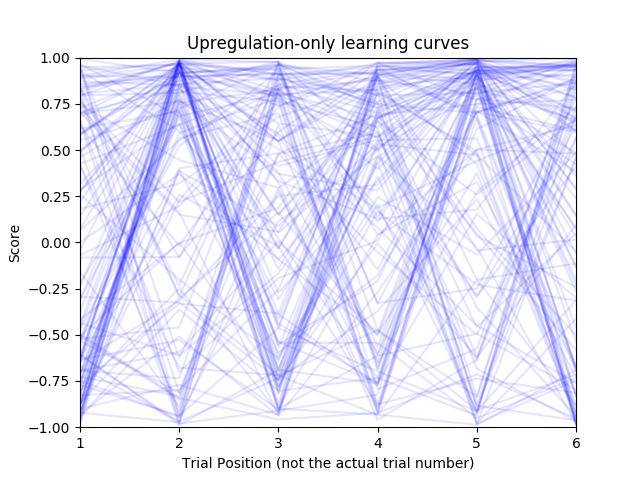

In [7]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
useries = pd.DataFrame(upseries)
useries = useries.sort_values(by=['ID'])
useries = useries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(useries)):
    ax.plot(x, useries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('Upregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Now I'll check histograms for each trial. I think I'll try downregulation-only to avoid mixing them.

            ID         1         2         3         4         5         6
55   A00028185 -0.666508  0.735094  0.970328  0.558695 -0.719157 -0.780337
74   A00032875 -0.898489 -0.895583 -0.651572 -0.911242 -0.655593  0.839463
109  A00033747  0.959709 -0.280033 -0.699137  0.862805  0.913998  0.908893
37   A00034854 -0.620713 -0.313419  0.550405  0.957702  0.985941  0.812171
7    A00035072  0.085656  0.790296  0.584729  0.695452  0.941998  0.646857
..         ...       ...       ...       ...       ...       ...       ...
42   A00066827  0.281650  0.744215 -0.930396 -0.901703 -0.760790  0.974477
28   A00066926 -0.546585  0.980773  0.846103  0.597506  0.892420 -0.330294
34   A00072203 -0.092233 -0.112006  0.634697 -0.116508  0.432027 -0.712339
2    A00073600 -0.822535 -0.392421 -0.337617  0.869577  0.832783  0.375537
72   A00073677 -0.978632  0.869675  0.966693 -0.319988 -0.826052 -0.563680

[138 rows x 7 columns]


<IPython.core.display.Javascript object>


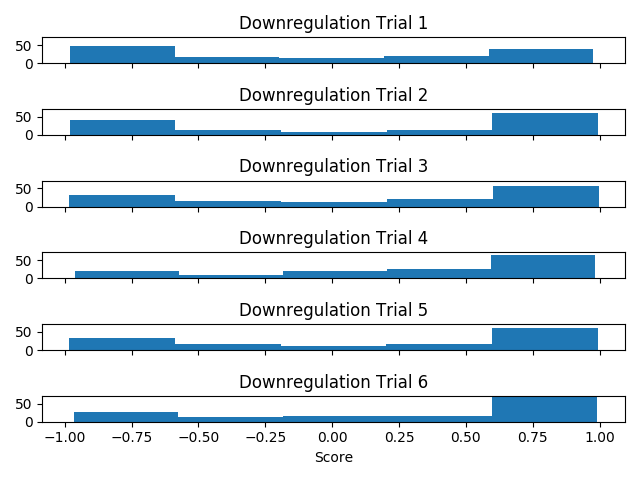

In [21]:
import matplotlib
import matplotlib.pyplot as plt

dseries = pd.DataFrame(downseries)
dseries = dseries.sort_values(by=['ID'])
print(dseries)

n_bins = 5

fig, axs = plt.subplots(6, 1, sharey=True, sharex=True)
for trialPos in range(6):
    axs[trialPos].hist(dseries[str(trialPos + 1)].to_list(), bins=n_bins)
    axs[trialPos].set_title('Downregulation Trial ' + str(trialPos + 1))
plt.xlabel('Score')
plt.tight_layout()
plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))